# Fibril Generator and CyRSoXS Simulation

In [1]:
from scipy.interpolate import interp1d
from scipy.ndimage import rotate
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import trimesh
import os
import pyembree
import random
import pickle
import sys
import pathlib
import subprocess
import h5py

from PyHyperScattering.load import cyrsoxsLoader
from PyHyperScattering.integrate import WPIntegrator

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import LogNorm

import numpy as np
import io
from PIL import Image
import PIL

import open3d as o3d

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\Phong\anaconda3\envs\smi_analysis\lib\site-packages\PyHyperScattering\load.py:1: UserWarning: Could not import astropy.io.fits, needed for ALS 11.0.1.2 RSoXS loading.  Is this dependency installed?
  from PyHyperScattering.ALS11012RSoXSLoader import ALS11012RSoXSLoader


Imports failed.  Are you running on a machine with proper libraries for databroker, tiled, etc.?


C:\Users\Phong\anaconda3\envs\smi_analysis\lib\site-packages\PyHyperScattering\integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator
C:\Users\Phong\anaconda3\envs\smi_analysis\lib\site-packages\PyHyperScattering\util.py:4: UserWarning: Could not import package for interactive integration utils.  Install holoviews and scikit-image.
  from PyHyperScattering import IntegrationUtils


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Define path to NRSS and PyHyperScattering

In [2]:
sys.path.append('C:/Users/Phong/NRSS/')
sys.path.append('C:/Users/Phong/DopantModeling')
from NRSS.writer import write_materials, write_hdf5, write_config, write_slurm
from NRSS.checkH5 import checkH5
from Morphology import Morphology 
from Fibril import Fibril
from PostProcessor import PostProcessor

## Load voxelized reduced morphology

In [3]:
from PostProcessor import PostProcessor

most_recent_file = None
most_recent_mtime = 0

# Iterate through all subdirectories and find the most recently modified .pickle file
for root, dirs, files in os.walk('.'):
    for filename in files:
        if filename.endswith('.pickle') and 'HDF5' not in os.listdir(root):
            full_path = os.path.abspath(os.path.join(root, filename))
            mtime = os.path.getmtime(full_path)
            if mtime > most_recent_mtime:
                most_recent_mtime = mtime
                most_recent_file = full_path

# Load the most recently modified .pickle file
rm = None
if most_recent_file:
    print(f"Loading the most recently modified file: {most_recent_file}")
    with open(most_recent_file, 'rb') as f:
        rm = pickle.load(f)
else:
    print("No pickle files found.")

Loading the most recently modified file: C:\Users\Phong\DopantModeling\Jupyter Notebooks\1024x1024x512nm_pitch2nm_rad15nm_std3nm_2250fib_50-200nm.pickle


## Create material matricies

In [4]:
VACUUM_ID  = 0 # Vacuum
CRYSTAL_ID = 1 # Crystalline P3HT
AMORPH_ID  = 2 # Amorphous P3HT
DOPANT_ID  = 3 # Dopant (optional)

mol_weight = {
    CRYSTAL_ID: 166.2842, # Molecular weight of crystalline P3HT
    AMORPH_ID: 166.2842,  # Molecular weight of amorphous P3HT
    DOPANT_ID: 276.15     # Molecular weight of TFSI- = 280.14, Molecular weight of F4TCNQ = 276.15
}

density = {
    CRYSTAL_ID: 1.1, # Density of crystalline P3HT
    AMORPH_ID: 1.1,  # Density of amorphous P3HT
    DOPANT_ID: 1.1   # Density of dopant in P3HT
}

# PostProcessor Setup
post_processor = PostProcessor(
    num_materials=4, mol_weight=mol_weight, density=density,
    dope_case=1, dopant_method='preferential', dopant_orientation='perpendicular', 
    dopant_vol_frac=0.08, crystal_dope_frac = 1,
    core_shell_morphology=True, gaussian_std=3, fibril_shell_cutoff=0.2, 
    surface_roughness=False, height_feature=3, max_valley_nm=46, 
    amorph_matrix_Vfrac=0.9, amorphous_orientation=True)

mat_Vfrac, mat_S, mat_theta, mat_psi = post_processor.generate_material_matrices(rm)

crystalline_mol_fraction, amorphous_mol_fraction, dopant_mol_fraction = post_processor.analyze_mol_fractions(mat_Vfrac)
print("")
print(f"Aggregate Mole Fraction = {crystalline_mol_fraction}")
print(f"Amorphous Mole Fraction = {amorphous_mol_fraction}")
print(f"Dopant Mole Fraction = {dopant_mol_fraction}")

crystalline_vol_fraction, amorphous_vol_fraction, dopant_vol_fraction = post_processor.analyze_vol_fractions(mat_Vfrac)
print("")
print(f"Aggregate Volume Fraction = {crystalline_vol_fraction}")
print(f"Amorphous Volume Fraction = {amorphous_vol_fraction}")
print(f"Dopant Volume Fraction = {dopant_vol_fraction}")

Iterating over fibrils:   1%|▎                                                       | 13/2250 [00:03<09:35,  3.89it/s]

KeyboardInterrupt



In [ ]:
phys_size = 2.0
write_hdf5([[mat_Vfrac[0], mat_S[0], mat_theta[0], mat_psi[0]], 
            [mat_Vfrac[1], mat_S[1], mat_theta[1], mat_psi[1]],
            [mat_Vfrac[2], mat_S[2], mat_theta[2], mat_psi[2]],
            [mat_Vfrac[3], mat_S[3], mat_theta[3], mat_psi[3]]],
            phys_size, 'Fibril.hdf5')

Dataset dimensions (Z, Y, X): 256 x 512 x 512
Number of Materials: 4

Material 1 Vfrac. Min: 0.0 Max: 0.09999999999999998
Material 1 S. Min: 0.0 Max: 0.0
Material 1 theta. Min: 0.0 Max: 0.0
Material 1 psi. Min: 0.0 Max: 0.0


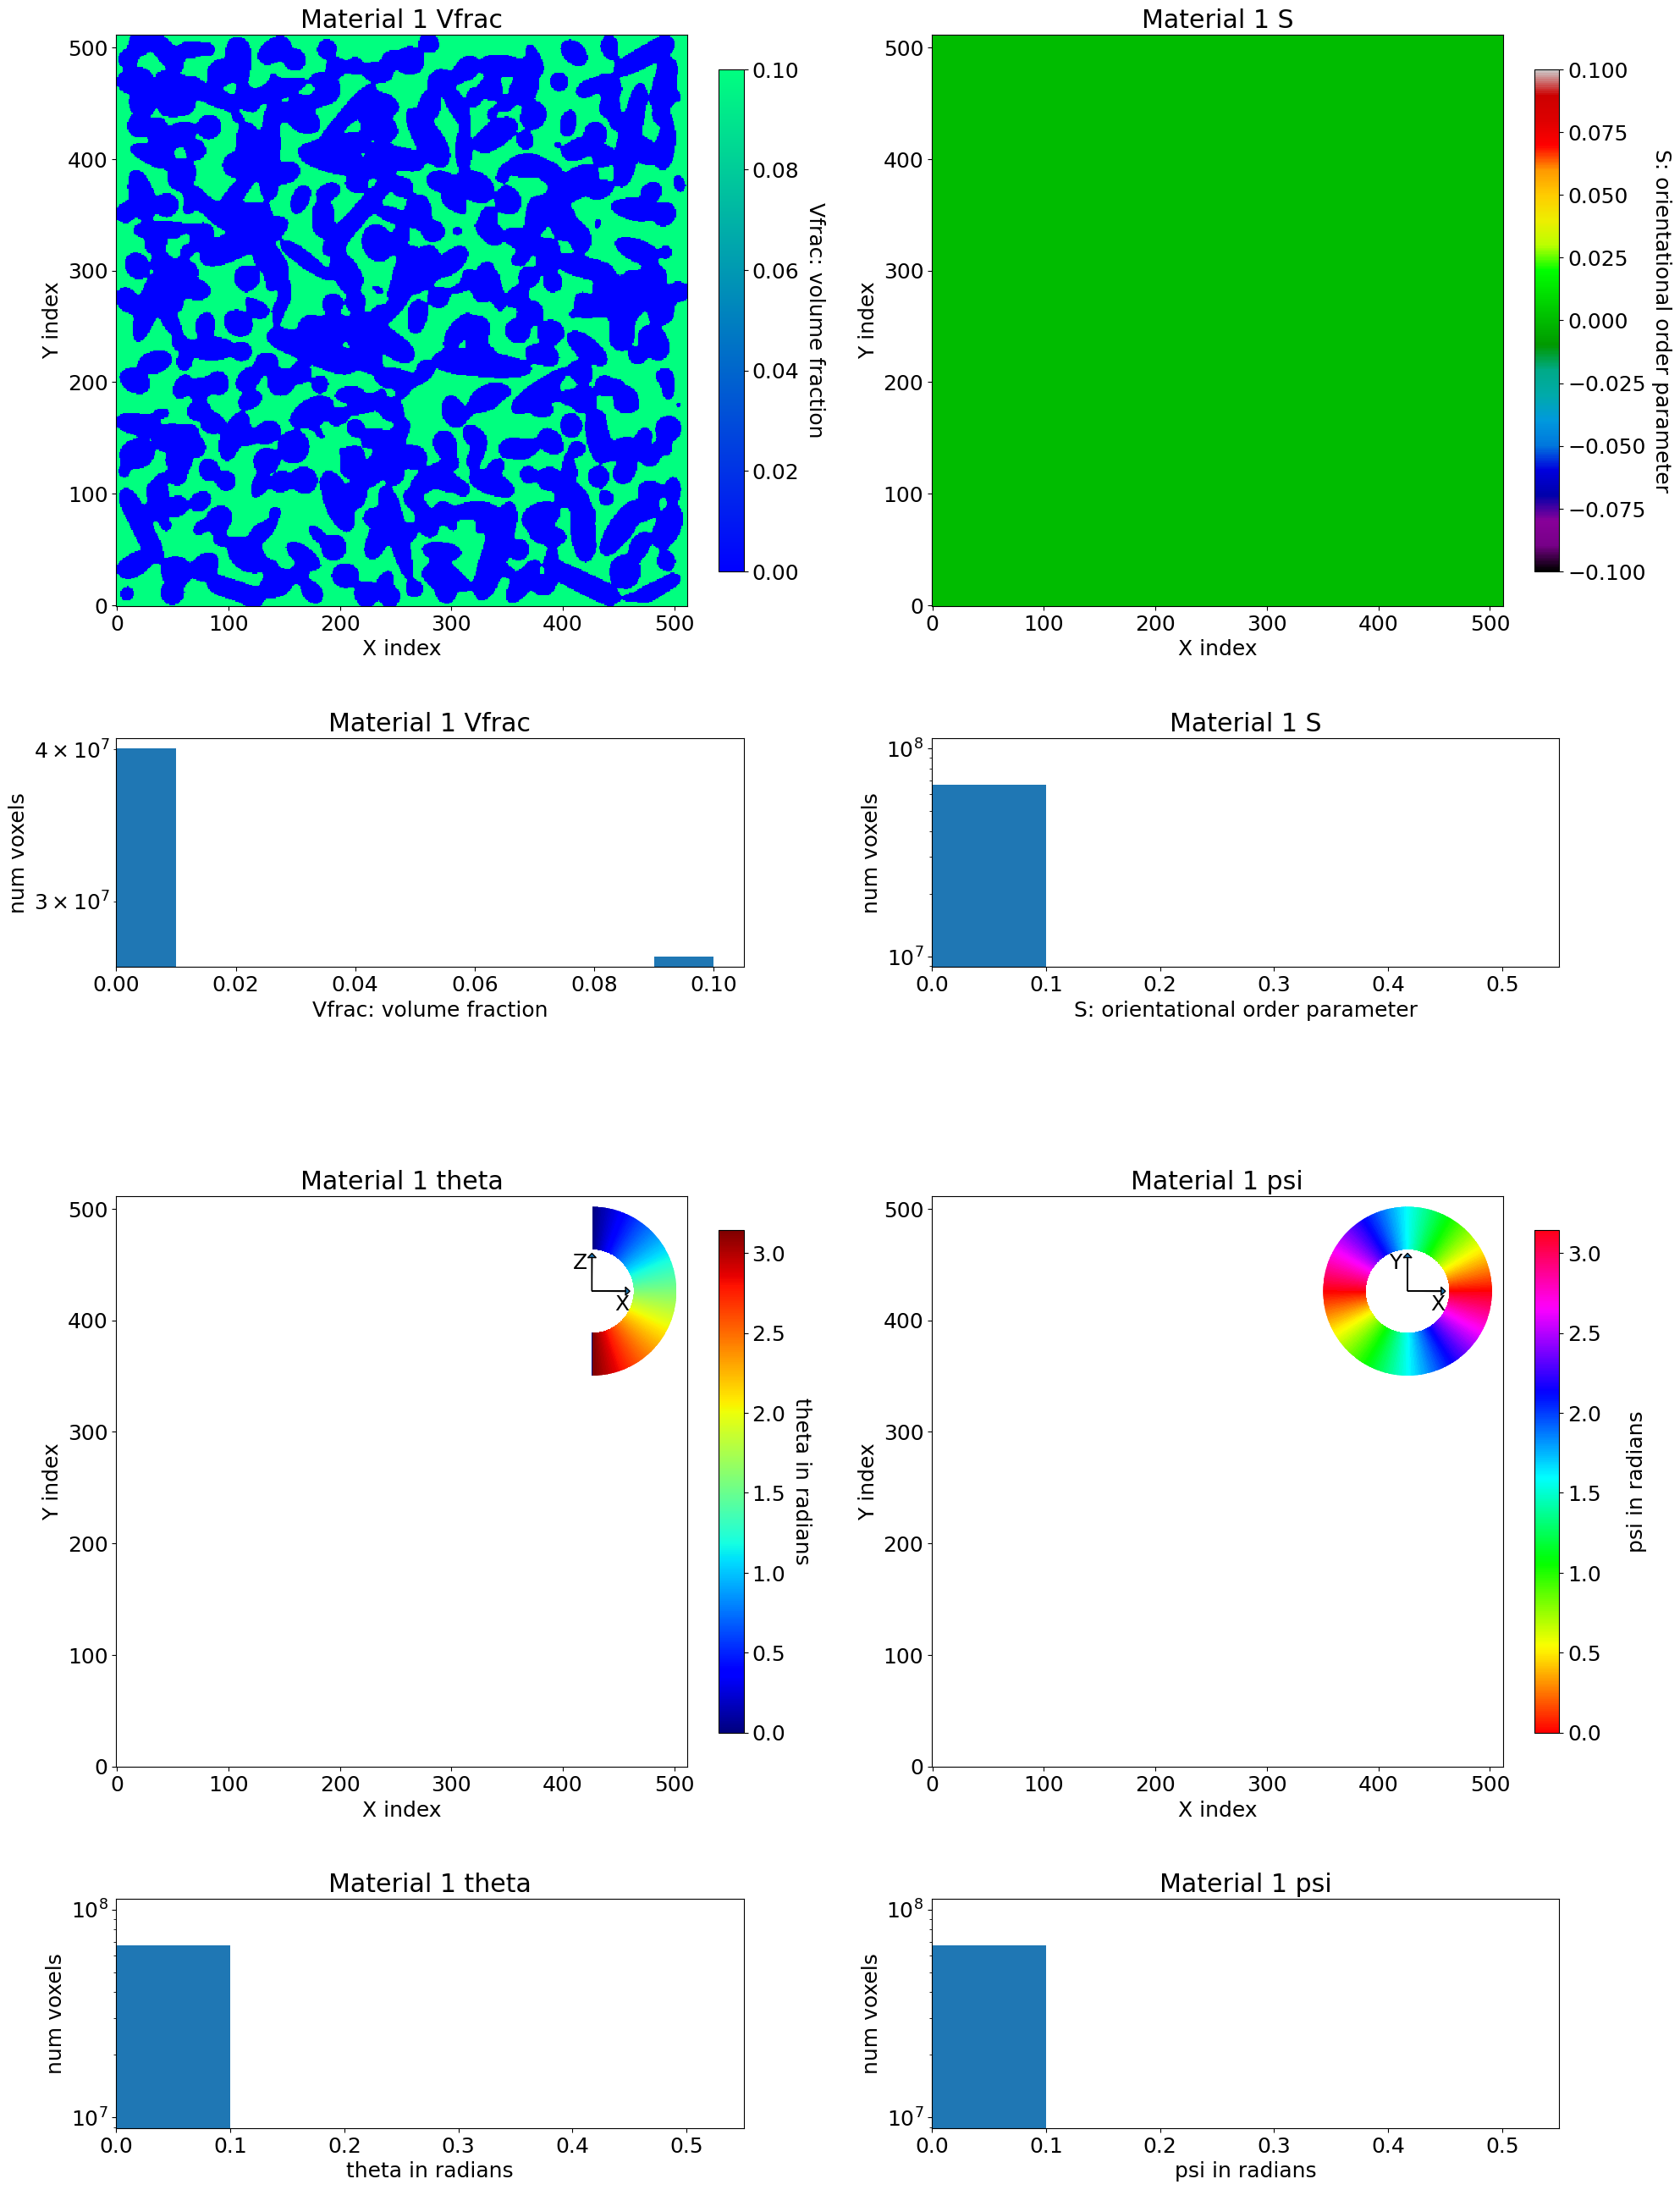

Material 2 Vfrac. Min: 0.0 Max: 0.9830655260418033
Material 2 S. Min: 0.0 Max: 1.0
Material 2 theta. Min: 0.0 Max: 3.1352897634977976
Material 2 psi. Min: 0.0 Max: 3.1415492288001365


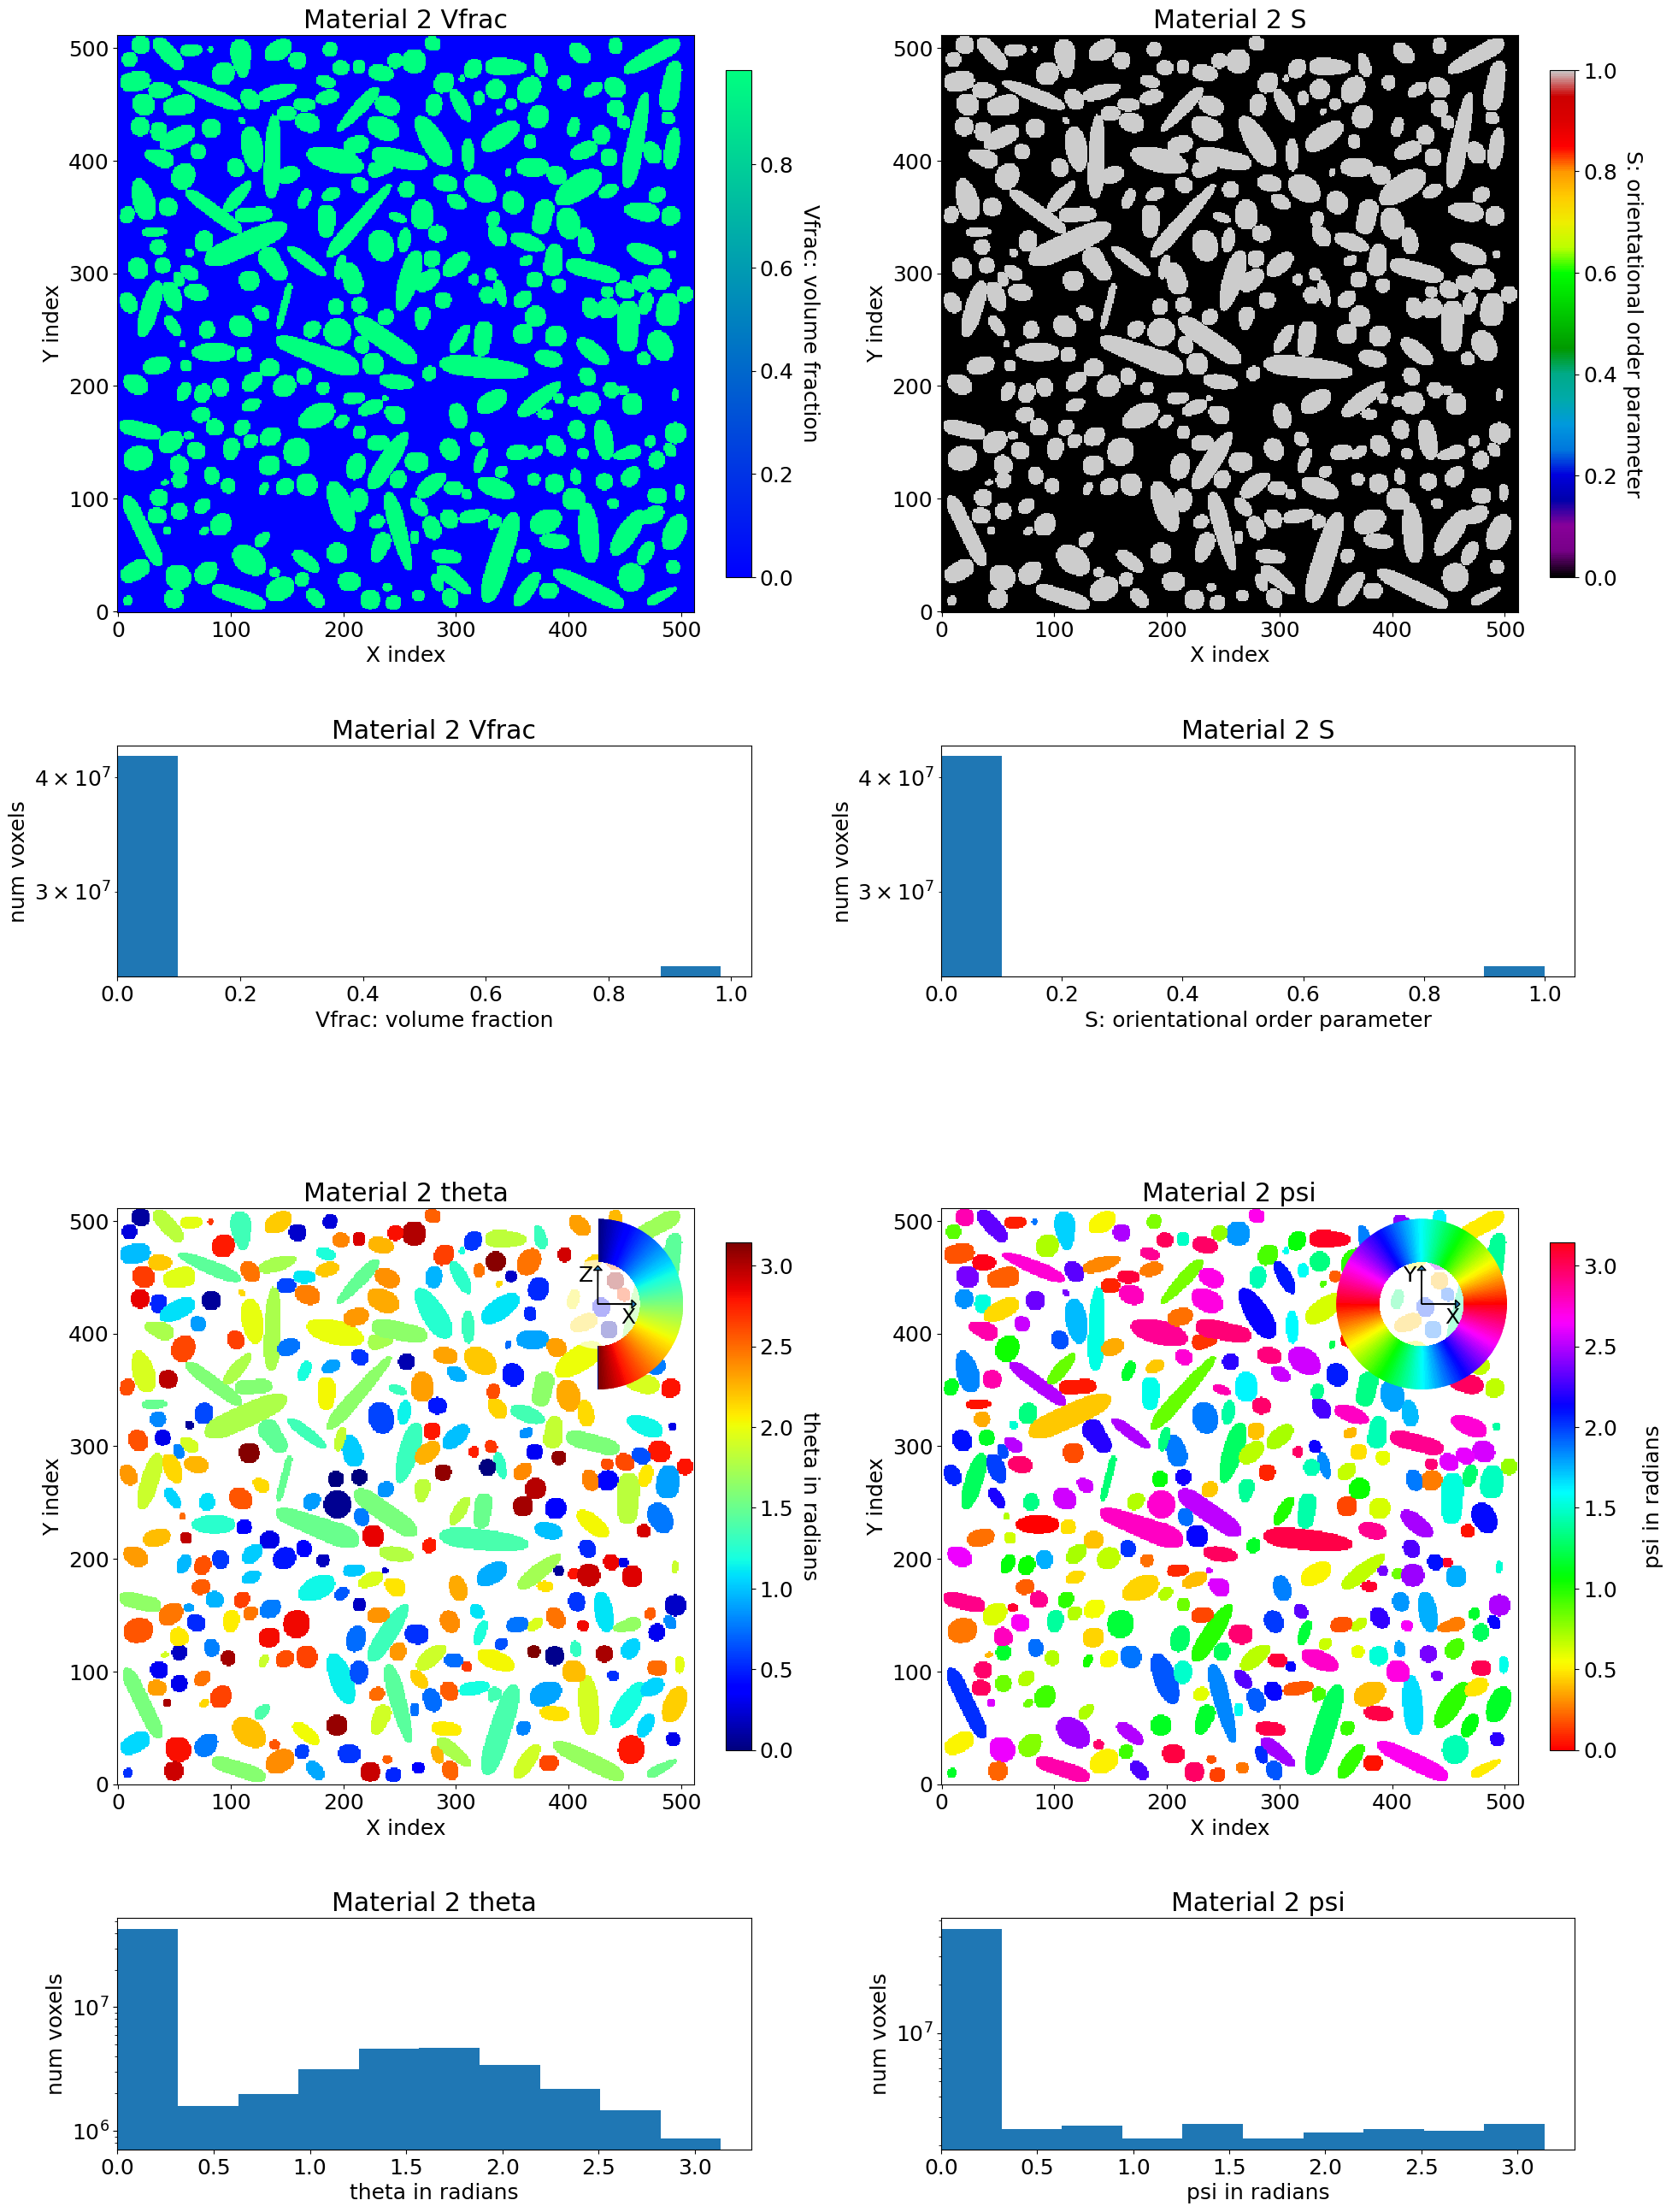

Material 3 Vfrac. Min: 0.0 Max: 0.9712310126998291
Material 3 S. Min: 0.0 Max: 1.0
Material 3 theta. Min: 0.0 Max: 3.1412667369437215
Material 3 psi. Min: 0.0 Max: 3.141592582192807


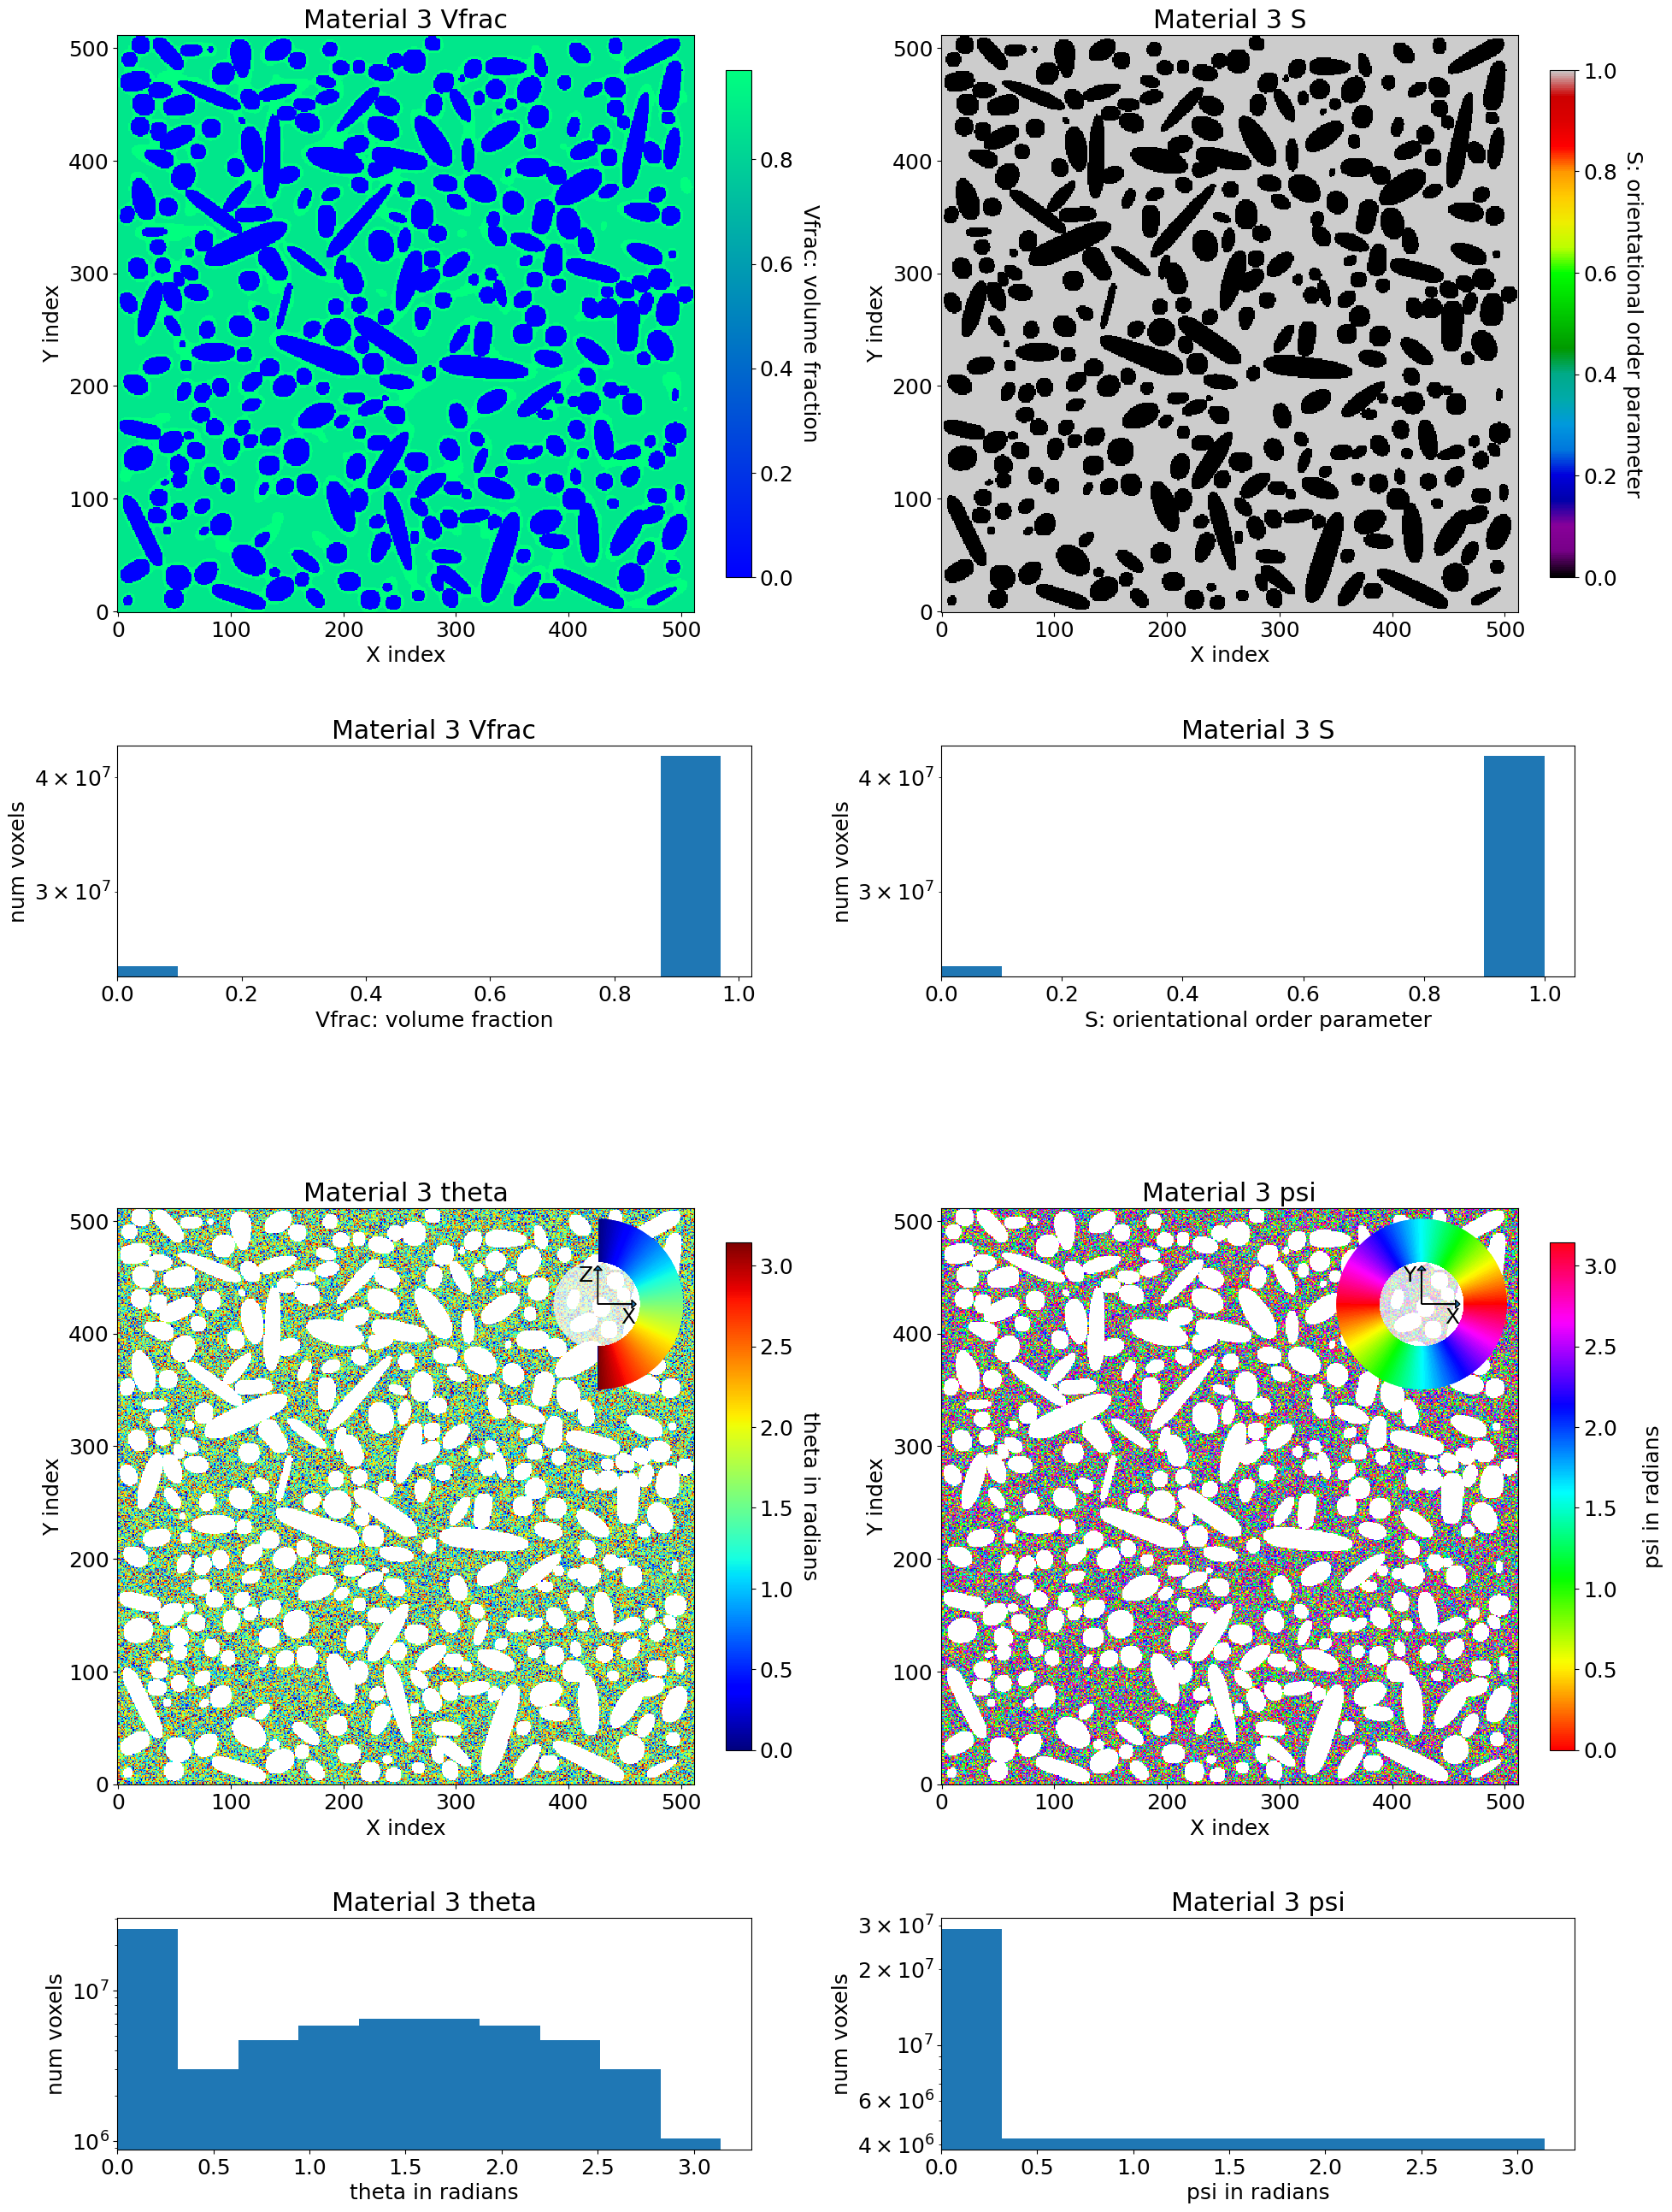

Material 4 Vfrac. Min: 0.016934473958196646 Max: 0.028768987300170884
Material 4 S. Min: 1.0 Max: 1.0
Material 4 theta. Min: 0.0003154018490777399 Max: 3.141526624197245
Material 4 psi. Min: 3.575820972656629e-08 Max: 3.141592190532884


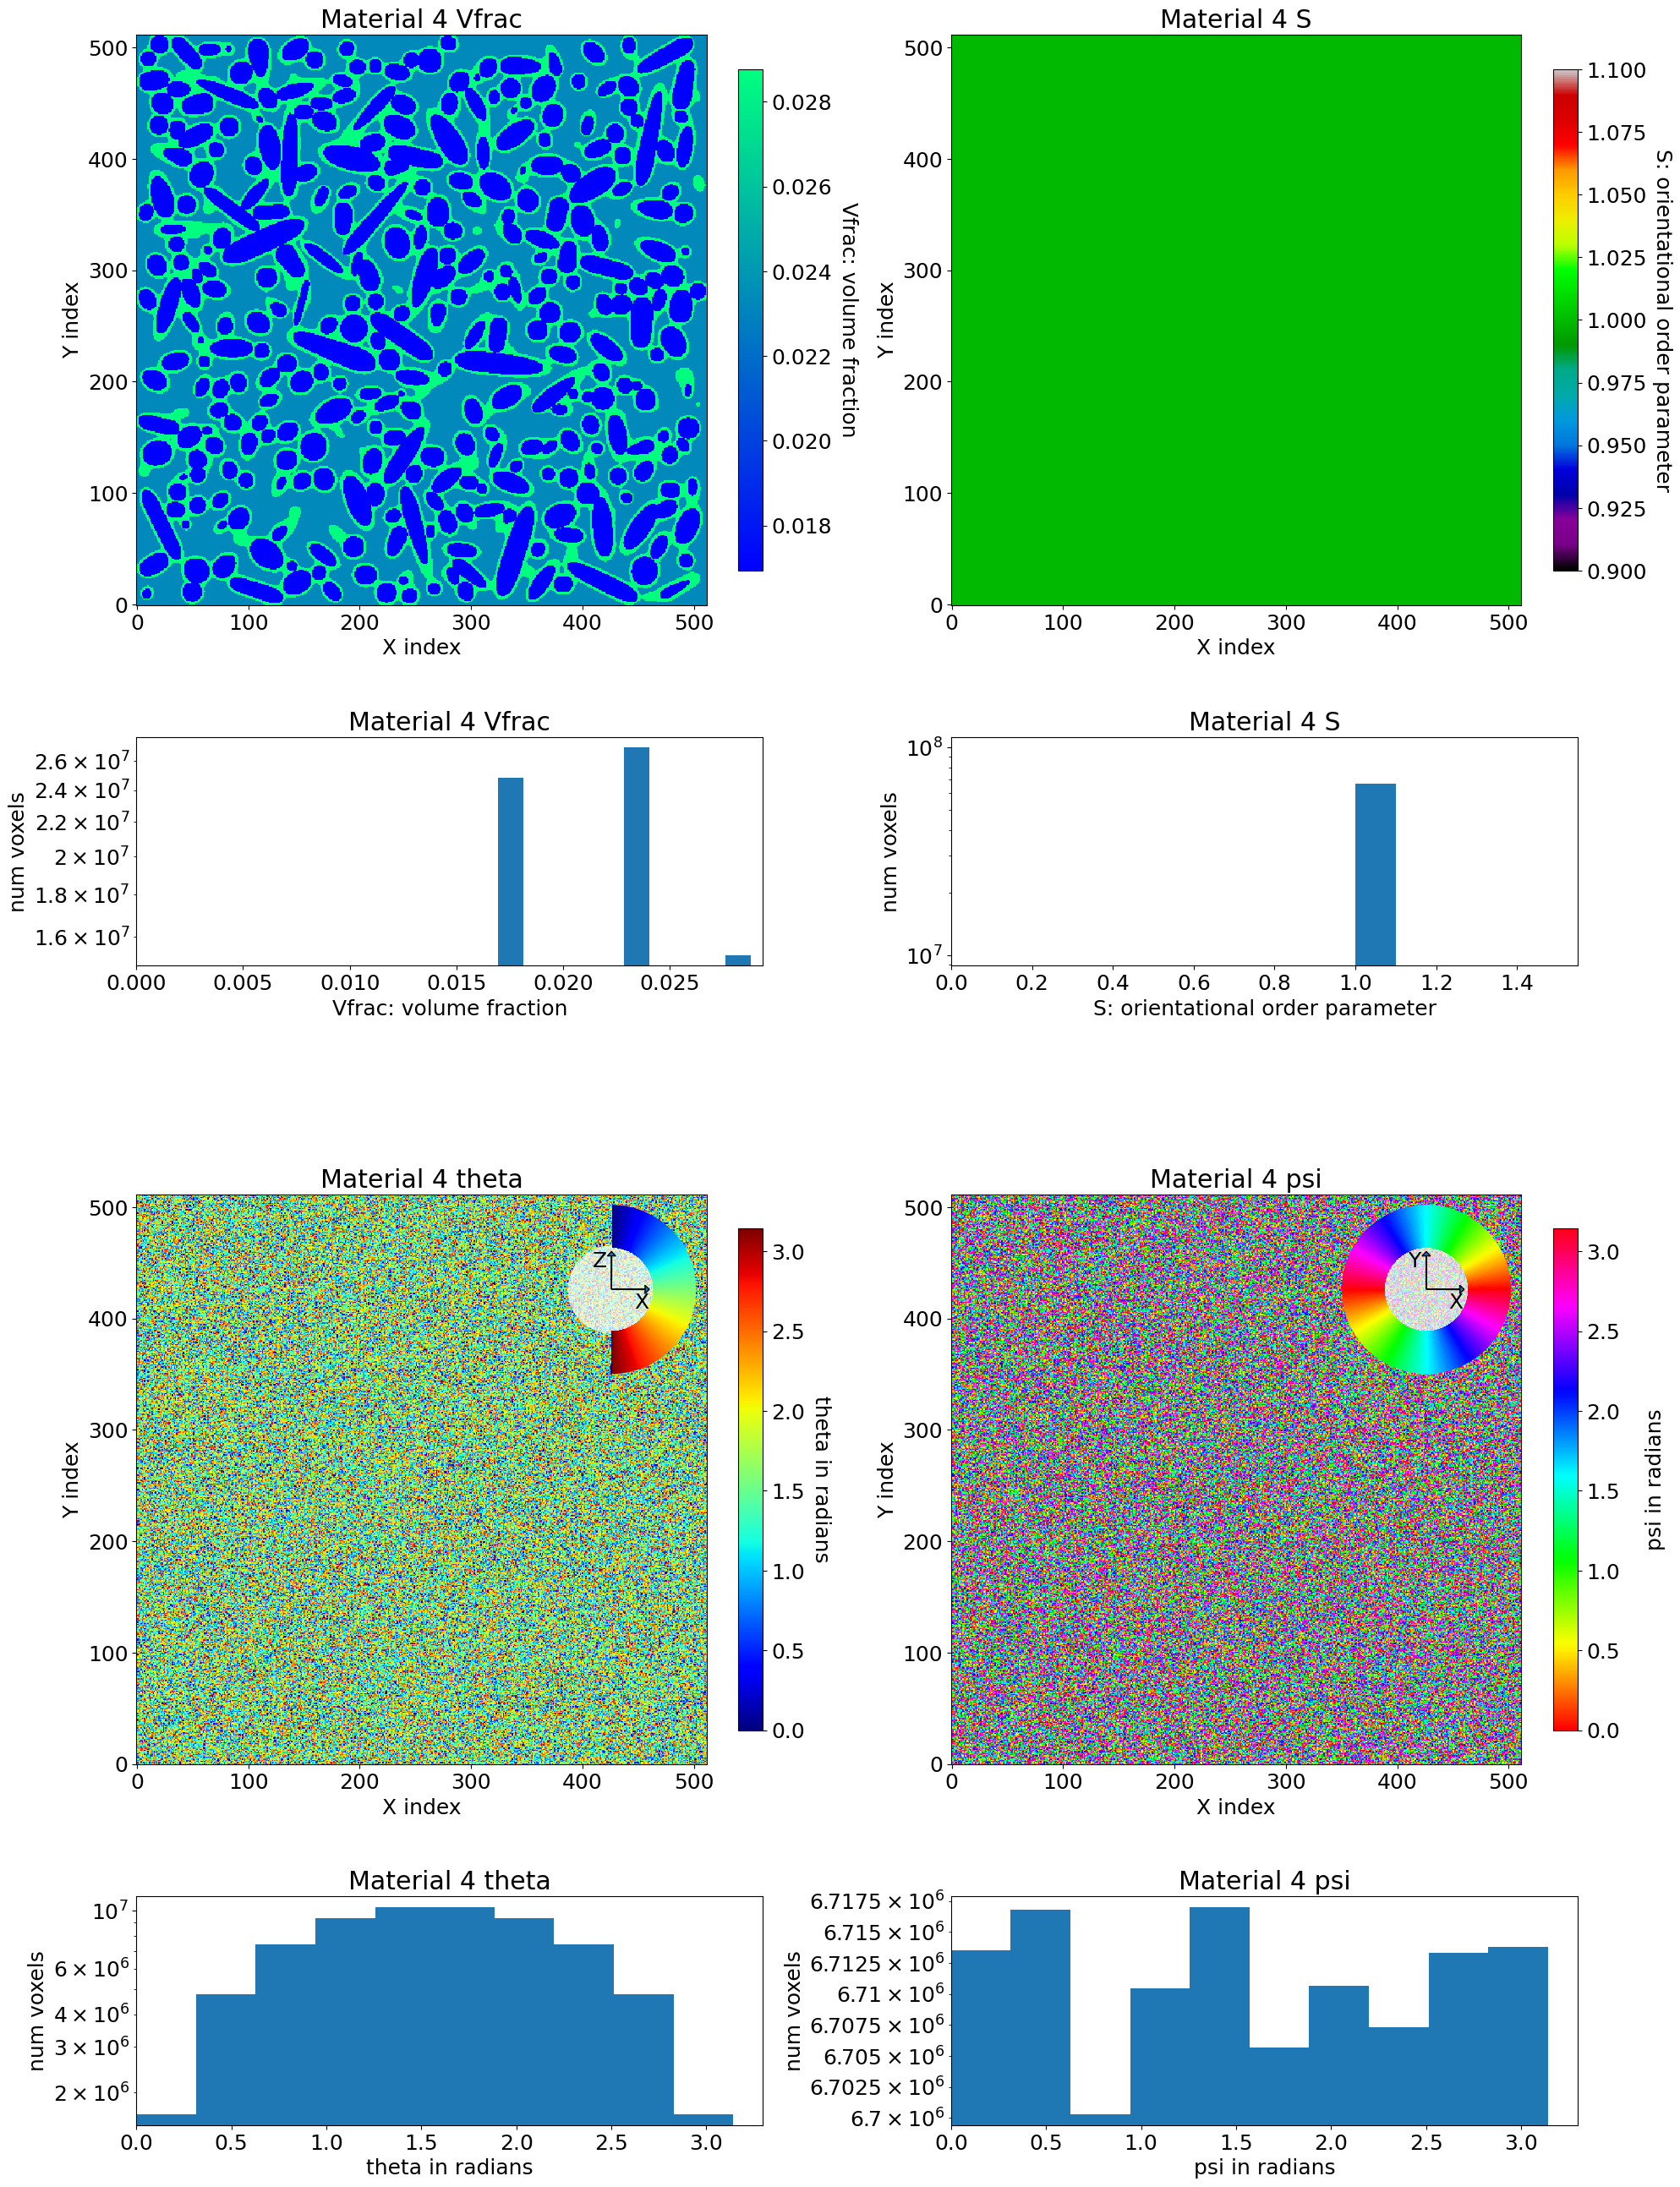

Total Vfrac whole model. Min: 1.0 Max: 1.0
0:01:30.400847


In [5]:
checkH5(r'C:\Users\Phong\Desktop\CyRSoXS\v2_sims\N_K_Edge_manual_Reduced_F4TCNQ\Phong_Pickled_Morphologies_v2_N_F4TCNQ_Everywhere\50-200nm\Average_Oriented\1024x1024x512nm_pitch2nm_rad15nm_std3nm_2250fib_50-200nm\1024x1024x512nm_pitch2nm_rad15nm_std3nm_2250fib_50-200nm.hdf5', z_slice=55, plotstyle='light')